# Unit 5 - Financial Planning


In [1]:
# Initial imports
import os
import requests
import datetime
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from pandas.tseries.offsets import DateOffset
%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()
find_dotenv()

'/Users/rajaabhishek/FinTech/API-Homework/.env'

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()

# Fetch current ETH price
eth_data = requests.get(eth_url).json()

# Compute current value of my crpto
my_btc_value = (btc_data["data"]['1']['quotes']['USD']['price'])*my_btc
my_eth_value = (eth_data["data"]['1027']['quotes']['USD']['price'])*my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $69057.60
The current value of your 5.3 ETH is $24696.73


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("alpaca_api_key")
alpaca_secret_key = os.getenv("alpaca_secret_key")

# Verify that Alpaca key and secret were correctly loaded
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [8]:
# Format current date as ISO format
current_date = pd.Timestamp.today(tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_ticker = alpaca.get_barset(
    tickers,
    timeframe,
    start = current_date,
    end = current_date
).df

# Preview DataFrame
#df_ticker.index=df_ticker.index.date
df_ticker

AGG                                      SPY  \
                             open    high     low   close   volume    open   
time                                                                         
2021-12-01 00:00:00-05:00  114.27  114.58  114.21  114.51  9179550  461.64   

                                                             
                             high     low   close    volume  
time                                                         
2021-12-01 00:00:00-05:00  464.67  456.85  457.92  69354259

In [9]:
# Pick AGG and SPY close prices
agg_close_price = df_ticker["AGG"]["close"][-1]
spy_close_price = df_ticker["SPY"]["close"][-1]
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $114.51
Current SPY closing price: $457.92


In [10]:
# Compute the current value of shares
my_spy_value = my_agg * agg_close_price
my_agg_value = my_spy* spy_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22902.00
The current value of your 200 AGG shares is $22896.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Create savings DataFrame
my_crypto_value = my_btc_value + my_eth_value
my_stock_value = my_spy_value + my_agg_value

df_savings = pd.DataFrame([[my_crypto_value],[my_stock_value]],columns = ["amount"], index=['crypto', 'shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,93754.328
shares,45798.000


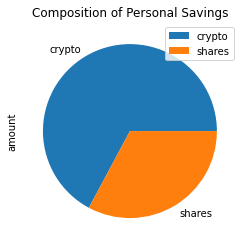

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y='amount',title = "Composition of Personal Savings");

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.iloc[0].sum() #df_savings.sum()

# Validate saving health
if total_savings > emergency_fund:
    print(f"congratulations you have enough money in emergency fund.")
elif total_savings == emergency_fund:
    print(f"congratulations for reaching emergency fund goal.")
else:
    print(f"you are ${emergency_fund - total_savings} away from reaching your emergency fund goal")

congratulations you have enough money in emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Setting today as end date for data pull.
e_date = datetime.date.today().strftime('%Y-%m-%d')

# Alpaca barset has limit of 1000 rows at a time and due to that 5 years of data can't be pulled in one go. 
# Due to the above reason, pulling 5 years of data using for loop

# Defining a blank dataframe to append multiple dataframe 
df_stock_data=pd.DataFrame()

#Defining a list incremental year to change the date in forloop
incremental_year = [5,4,3,2,1]

In [16]:
# Using for loop to pull the 5 years of data

for i in incremental_year:
    
    #Defining start date and converting it to isoformat
    start_date = pd.Timestamp(e_date)- DateOffset(years=i)
    start_date = pd.Timestamp(start_date,tz='America/New_York').isoformat()
    
    #Defining end date and converting it to isoformat
    end_date = pd.Timestamp(e_date)-DateOffset(years=i-1)
    end_date = pd.Timestamp(end_date,tz='America/New_York').isoformat()
    
    # Set the tickers
    tickers = ["AGG", "SPY"]

    # Set timeframe to '1D' for Alpaca API
    timeframe = "1D"
    
    # Get 1 year worth of historical data for SPY and AGG in one pull
    
    df_stock_data1 = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit=1000
    ).df
    
    # Drop the time component of the date
    df_stock_data1.index = df_stock_data1.index.date
    
    # Append pulled data from Alpaca to DataFrame df_stock_data
    df_stock_data = pd.concat([df_stock_data,df_stock_data1])
    
# start date of one pull is overlapping with end date of previous pull which creates duplicates for few dates.
# removing duplicates
df_stock_data.drop_duplicates(inplace=True)

# Display data
df_stock_data

AGG                                               SPY  \
              open      high       low    close      volume     open   
2016-12-01  107.75  107.7900  107.4650  107.710   4354843.0  220.705   
2016-12-02  107.93  108.1999  107.8500  108.020   4041171.0  219.670   
2016-12-05  107.94  108.2600  107.7800  108.080   2618727.0  220.650   
2016-12-06  108.14  108.1800  108.0400  108.080   3096692.0  221.220   
2016-12-07  108.22  108.3800  108.2000  108.370   3513943.0  221.520   
...            ...       ...       ...      ...         ...      ...   
2021-11-24  113.47  113.7250  113.3905  113.720   5959367.0  466.060   
2021-11-26  114.28  114.5769  114.2000  114.540   2886169.0  462.380   
2021-11-29  114.15  114.6000  114.1300  114.550   7604952.0  464.070   
2021-11-30  114.87  115.1074  114.5000  114.765  10624796.0  462.000   
2021-12-01  114.27  114.5800  114.2100  114.490   9186099.0  461.640   

                                                  
                high      low   close     volume  
2016-12-01  220.7300  219.150  219.52   64081700  
2016-12-02  220.2500  219.260  219.66   54564756  
2016-12-05  221.4000  220.420  220.92   49535522  
2016-12-06  221.7441  220.662  221.69   43883404  
2016-12-07  224.6700  221.380  224.57   82719158  
...              ...      ...     ...        ...  
2021-11-24  469.5700  465.190  469.37   54274217  
2021-11-26  463.9000  457.770  459.03   93783057  
2021-11-29  466.5600  461.730  464.63   68239627  
2021-11-30  464.0300  455.300  455.78  126435765  
2021-12-01  464.6700  456.850  458.53   69752566  

[1259 rows x 10 columns]

In [17]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
mcs_30yr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [18]:
# Printing the simulation input data
mcs_30yr.portfolio_data.head()

AGG                                                     \
              open      high      low   close     volume daily_return   
2016-12-01  107.75  107.7900  107.465  107.71  4354843.0          NaN   
2016-12-02  107.93  108.1999  107.850  108.02  4041171.0     0.002878   
2016-12-05  107.94  108.2600  107.780  108.08  2618727.0     0.000555   
2016-12-06  108.14  108.1800  108.040  108.08  3096692.0     0.000000   
2016-12-07  108.22  108.3800  108.200  108.37  3513943.0     0.002683   

                SPY                                                    
               open      high      low   close    volume daily_return  
2016-12-01  220.705  220.7300  219.150  219.52  64081700          NaN  
2016-12-02  219.670  220.2500  219.260  219.66  54564756     0.000638  
2016-12-05  220.650  221.4000  220.420  220.92  49535522     0.005736  
2016-12-06  221.220  221.7441  220.662  221.69  43883404     0.003485  
2016-12-07  221.520  224.6700  221.380  224.57  82719158     0.012991

In [19]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
mcs_30yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/rajaabhishek/FinTech/API-Homework/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.987552,1.006102,1.007328,1.012037,0.990648,1.015184,0.992391,1.000601,1.011191,0.994581,...,0.995095,0.999449,0.998516,1.009544,1.000717,0.994567,1.003031,1.016063,1.017186,0.999665
2,0.976412,1.009919,1.005260,1.017374,0.987636,1.014636,1.000295,0.993451,1.022289,0.996407,...,0.989789,1.003110,0.994644,0.996209,1.002488,0.998538,1.008716,1.024909,1.021383,0.994535
3,0.978475,0.997072,1.003857,1.025992,0.976638,1.016787,0.995441,0.990345,1.024699,0.999599,...,0.981084,1.010561,1.006086,0.995245,1.000425,0.994718,0.997853,1.020475,1.030168,0.997455
4,0.972435,0.995466,1.006679,1.031359,0.976324,1.017636,0.996583,0.998042,1.030248,0.998515,...,0.987534,1.014984,1.014406,0.996212,1.005068,0.989043,0.998145,1.031949,1.019077,0.998346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,11.220274,8.409910,24.025829,43.331281,31.158551,24.129803,26.406577,15.204225,22.776426,21.246336,...,35.048767,58.547222,33.980552,26.810274,17.835986,10.905910,10.746765,17.652438,45.897944,42.018738
7557,11.206106,8.403855,24.106068,42.701408,31.439216,24.000217,26.433869,15.230315,22.660719,21.126494,...,35.339275,58.427597,34.173965,27.028870,17.693542,10.987209,10.725176,17.508182,45.535885,42.599294
7558,11.250807,8.421917,24.027943,42.916462,31.435505,24.075948,26.144163,15.169799,22.839233,21.221975,...,34.940763,58.092247,34.104232,27.321452,17.892451,10.908474,10.674895,17.737639,45.447511,43.040813
7559,11.177981,8.428665,24.018152,43.136479,31.444920,23.931575,26.059191,15.100593,22.655513,21.288468,...,35.083469,58.024899,34.181166,27.145407,17.765715,11.001802,10.748794,17.570806,45.194891,43.257625


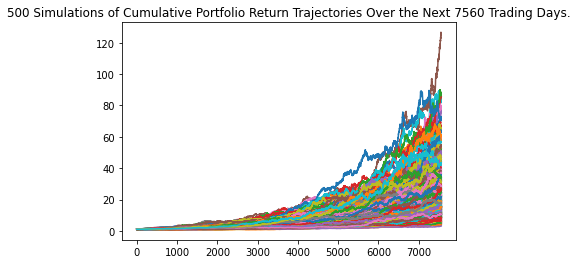

In [20]:
# Plot simulation outcomes
mcs_30yr.plot_simulation();

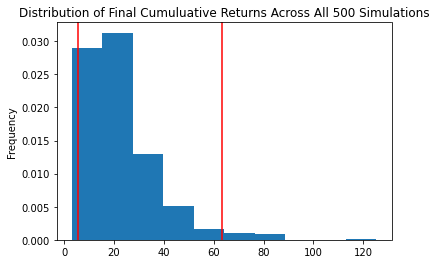

In [21]:
# Plot probability distribution and confidence intervals
mcs_30yr.plot_distribution();

### Retirement Analysis

In [22]:
# Fetch summary statistics from the Monte Carlo simulation results
summ_tbl = mcs_30yr.summarize_cumulative_return()

# Print summary statistics
print(summ_tbl)

count           500.000000
mean             22.766649
std              14.819282
min               3.145954
25%              13.060925
50%              18.919980
75%              28.215977
max             125.233743
95% CI Lower      5.576120
95% CI Upper     63.382788
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summ_tbl[8]*initial_investment,2)
ci_upper = round(summ_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $111522.4 and $1267655.77


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [24]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summ_tbl[8]*initial_investment,2)
ci_upper = round(summ_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $167283.6 and $1901483.65


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [25]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mcs_5yr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*5
)
# Printing the simulation input data
mcs_5yr.portfolio_data.head()

AGG                                                     \
              open      high      low   close     volume daily_return   
2016-12-01  107.75  107.7900  107.465  107.71  4354843.0          NaN   
2016-12-02  107.93  108.1999  107.850  108.02  4041171.0     0.002878   
2016-12-05  107.94  108.2600  107.780  108.08  2618727.0     0.000555   
2016-12-06  108.14  108.1800  108.040  108.08  3096692.0     0.000000   
2016-12-07  108.22  108.3800  108.200  108.37  3513943.0     0.002683   

                SPY                                                    
               open      high      low   close    volume daily_return  
2016-12-01  220.705  220.7300  219.150  219.52  64081700          NaN  
2016-12-02  219.670  220.2500  219.260  219.66  54564756     0.000638  
2016-12-05  220.650  221.4000  220.420  220.92  49535522     0.005736  
2016-12-06  221.220  221.7441  220.662  221.69  43883404     0.003485  
2016-12-07  221.520  224.6700  221.380  224.57  82719158     0.012991

In [26]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mcs_5yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/rajaabhishek/FinTech/API-Homework/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011203,1.007427,0.999958,0.998997,0.998782,1.007924,1.006619,1.009775,0.985425,1.001521,...,1.013116,0.989263,0.987680,1.010859,1.009088,1.010674,1.004890,0.976877,0.993100,1.003730
2,1.010069,1.022086,0.997342,1.000772,0.987802,1.008075,0.989884,1.013290,0.984314,1.026628,...,1.011637,0.987346,0.981751,1.001616,1.014631,1.006735,1.008124,0.977166,0.998194,1.007504
3,1.002668,1.013694,1.005749,1.001369,0.989440,1.015035,0.990087,1.008954,0.982141,1.020244,...,1.011393,0.980383,0.981408,0.997677,1.014439,1.010729,1.006898,0.972391,0.990338,0.996759
4,1.005155,1.012941,1.010082,0.999816,0.990792,1.021103,0.997253,1.000907,0.974825,1.005834,...,1.004869,0.984469,0.990414,0.994758,1.013514,1.010859,1.013384,0.977152,0.982415,0.981153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.414777,1.410275,1.152097,1.706680,1.252088,1.688654,1.805586,2.403015,1.446505,1.531231,...,1.224041,2.625842,2.580553,2.308725,1.984544,1.862659,1.912021,1.538299,1.515286,1.430559
1257,1.423312,1.410595,1.157274,1.665997,1.243320,1.726614,1.829806,2.401220,1.448014,1.551122,...,1.218144,2.608738,2.538498,2.311055,1.977524,1.875566,1.911141,1.553275,1.521588,1.423541
1258,1.401087,1.411035,1.166955,1.679888,1.239337,1.721130,1.830581,2.393224,1.417812,1.548268,...,1.213826,2.644213,2.525532,2.312989,1.969321,1.872242,1.893438,1.557145,1.516243,1.428386
1259,1.401870,1.404060,1.160787,1.687439,1.247215,1.723091,1.839628,2.400393,1.418892,1.550107,...,1.219838,2.626948,2.511633,2.331932,1.943032,1.875845,1.873034,1.547729,1.513551,1.438272


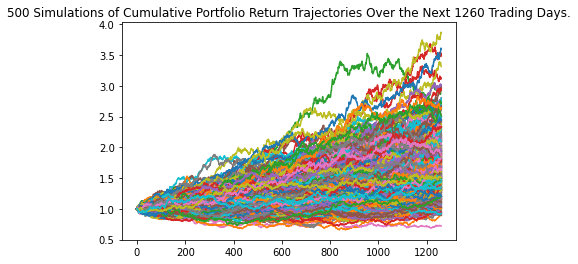

In [27]:
# Plot simulation outcomes
mcs_5yr.plot_simulation();

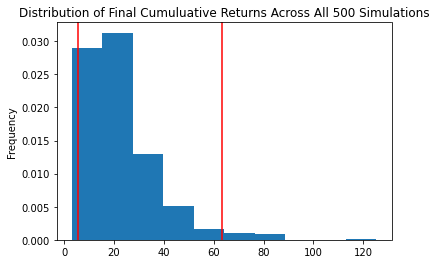

In [28]:
# Plot probability distribution and confidence intervals
mcs_30yr.plot_distribution();

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
summ_tbl_5 = mcs_5yr.summarize_cumulative_return()

# Print summary statistics
print(summ_tbl_5)

count           500.000000
mean              1.697582
std               0.462343
min               0.719237
25%               1.358893
50%               1.665561
75%               1.949573
max               3.863175
95% CI Lower      0.955146
95% CI Upper      2.711753
Name: 1260, dtype: float64


In [30]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(summ_tbl_5[8]*initial_investment,2)
ci_upper_five = round(summ_tbl_5[9]*initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57308.76 and $162705.18


### Ten Years Retirement Option

In [32]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mcs_10yr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*10
)
# Printing the simulation input data
mcs_10yr.portfolio_data.head()

AGG                                                     \
              open      high      low   close     volume daily_return   
2016-12-01  107.75  107.7900  107.465  107.71  4354843.0          NaN   
2016-12-02  107.93  108.1999  107.850  108.02  4041171.0     0.002878   
2016-12-05  107.94  108.2600  107.780  108.08  2618727.0     0.000555   
2016-12-06  108.14  108.1800  108.040  108.08  3096692.0     0.000000   
2016-12-07  108.22  108.3800  108.200  108.37  3513943.0     0.002683   

                SPY                                                    
               open      high      low   close    volume daily_return  
2016-12-01  220.705  220.7300  219.150  219.52  64081700          NaN  
2016-12-02  219.670  220.2500  219.260  219.66  54564756     0.000638  
2016-12-05  220.650  221.4000  220.420  220.92  49535522     0.005736  
2016-12-06  221.220  221.7441  220.662  221.69  43883404     0.003485  
2016-12-07  221.520  224.6700  221.380  224.57  82719158     0.012991

In [33]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mcs_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/rajaabhishek/FinTech/API-Homework/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997759,1.001427,0.991564,1.004676,0.993648,0.993511,1.003067,1.007911,1.003671,0.999565,...,1.008392,1.006193,1.004269,0.988966,1.003836,0.997374,1.004656,0.992672,1.010353,0.994023
2,0.994020,0.996848,0.994107,1.005364,0.990514,0.996225,1.014384,1.012461,0.997201,0.990348,...,1.012554,1.017375,1.006789,1.001363,1.009263,1.004848,0.997170,0.985733,1.010333,0.996102
3,1.006560,1.005771,0.997985,1.004208,0.988973,0.989159,1.016496,1.004545,0.996113,0.976291,...,1.021338,1.019637,1.007226,0.999832,1.015433,1.001859,0.979226,0.987493,1.013769,1.006481
4,0.999767,1.004210,0.989642,1.011755,0.984337,0.982977,1.020581,1.015635,0.996628,0.977923,...,1.032086,1.013851,1.006054,1.002857,1.017562,0.997673,0.984001,0.987710,1.015686,1.012489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,5.419157,3.480778,1.611218,2.441276,3.989266,1.735226,2.080906,2.152613,1.492242,3.616796,...,1.324533,1.902819,1.879564,4.466664,4.068761,2.203479,1.964355,2.794882,2.149448,4.884042
2517,5.378333,3.468876,1.606909,2.414001,4.025344,1.722567,2.064391,2.159118,1.479433,3.623617,...,1.343043,1.905227,1.868676,4.479698,4.095639,2.207813,1.973976,2.815779,2.117974,4.903499
2518,5.401155,3.454268,1.625680,2.405462,4.034661,1.729956,2.070457,2.156665,1.477853,3.633883,...,1.355047,1.908905,1.883963,4.430332,4.150977,2.209029,1.978622,2.837760,2.100798,4.938731
2519,5.381647,3.496688,1.636618,2.396611,4.018912,1.740819,2.078204,2.156139,1.491397,3.658953,...,1.369500,1.911652,1.889903,4.428910,4.151798,2.213877,1.985103,2.836212,2.106664,4.875268


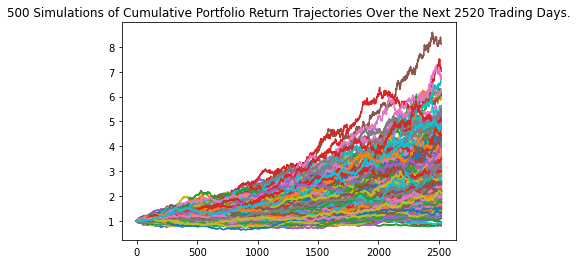

In [34]:
# Plot simulation outcomes
mcs_10yr.plot_simulation();

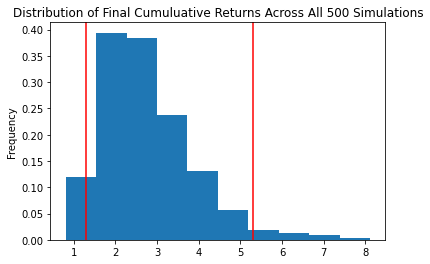

In [35]:
# Plot probability distribution and confidence intervals
mcs_10yr.plot_distribution();

In [36]:
# Fetch summary statistics from the Monte Carlo simulation results
summ_tbl_10 = mcs_10yr.summarize_cumulative_return()

# Print summary statistics
print(summ_tbl_10)

count           500.000000
mean              2.768880
std               1.084557
min               0.805496
25%               2.009229
50%               2.594774
75%               3.292427
max               8.115629
95% CI Lower      1.288081
95% CI Upper      5.301571
Name: 2520, dtype: float64


In [37]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(summ_tbl_10[8]*initial_investment,2)
ci_upper_ten = round(summ_tbl_10[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $77284.86 and $318094.27
